# EDA: Berita FAKE vs REAL 

Notebook ini adalah panduan lengkap untuk melakukan Data Profiling dan Analisis Data Eksplorasi (EDA) pada dataset berita `fake_or_real_news.csv`. Tujuannya adalah untuk memahami karakteristik data teks secara mendalam sebelum masuk ke tahap pemodelan.

Link : https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news/data

## 1. Data Acquisition

### 1.1 Import Library

In [1]:
# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

# Mengatur agar plot ditampilkan di dalam notebook
%matplotlib inline

print("Library siap digunakan!")

Library siap digunakan!


### 1.2 Memuat Dataset

In [2]:
# Membaca file CSV ke dalam DataFrame
df = pd.read_csv('data/text_real_or_fake_news.csv')

# Menampilkan 5 baris pertama data
print("5 baris pertama dari dataset:")
df.head()

5 baris pertama dari dataset:


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## 2. Data Profiling / Exploratory Data Analysis (EDA)

### 2.1 Informasi Dasar DataFrame

In [5]:
# Menampilkan informasi ringkas (tipe data, memori, dll.)
print("Informasi Umum Dataset:")
df.info()

print("\nStatistik Deskriptif:")

# Memeriksa jumlah nilai yang hilang (missing values) per kolom
print("Jumlah Nilai yang Hilang per Kolom:")
print(df.isnull().sum())

Informasi Umum Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB

Statistik Deskriptif:
Jumlah Nilai yang Hilang per Kolom:
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


### 2.2 Analisis Distribusi Label

C:\Users\asus\AppData\Local\Temp\ipykernel_49376\2681745726.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


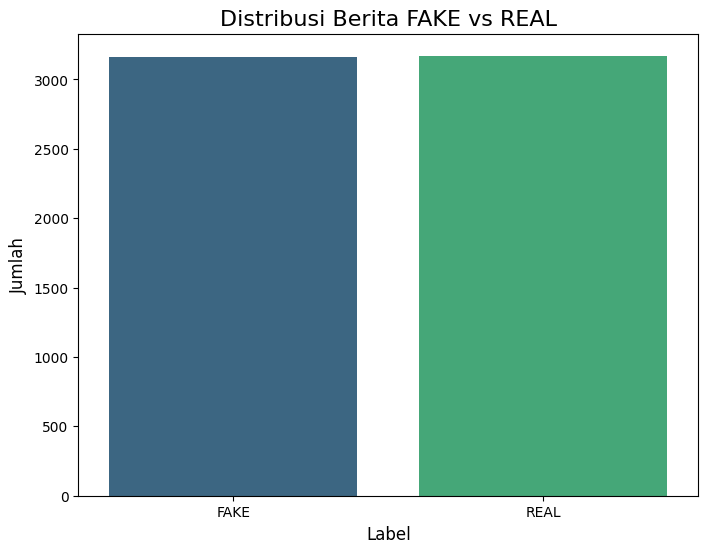

label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [6]:
# Visualisasi distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Berita FAKE vs REAL', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

# Menampilkan jumlah pastinya
print(df['label'].value_counts())

### 2.3 Analisis Karakteristik Teks

In [7]:
# Menghitung jumlah kata dalam setiap teks
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Menghitung jumlah karakter dalam setiap teks
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Menghitung panjang rata-rata kata
def avg_word_length(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

df['avg_word_length'] = df['text'].apply(avg_word_length)

print("Fitur baru berhasil ditambahkan (word_count, char_count, avg_word_length):")
df[['label', 'word_count', 'char_count', 'avg_word_length']].head()

Fitur baru berhasil ditambahkan (word_count, char_count, avg_word_length):


,label,word_count,char_count,avg_word_length
0,FAKE,1296,7518,4.776235
1,FAKE,446,2646,4.917040
2,REAL,431,2543,4.883991
3,FAKE,404,2660,5.554455
4,REAL,317,1840,4.776025


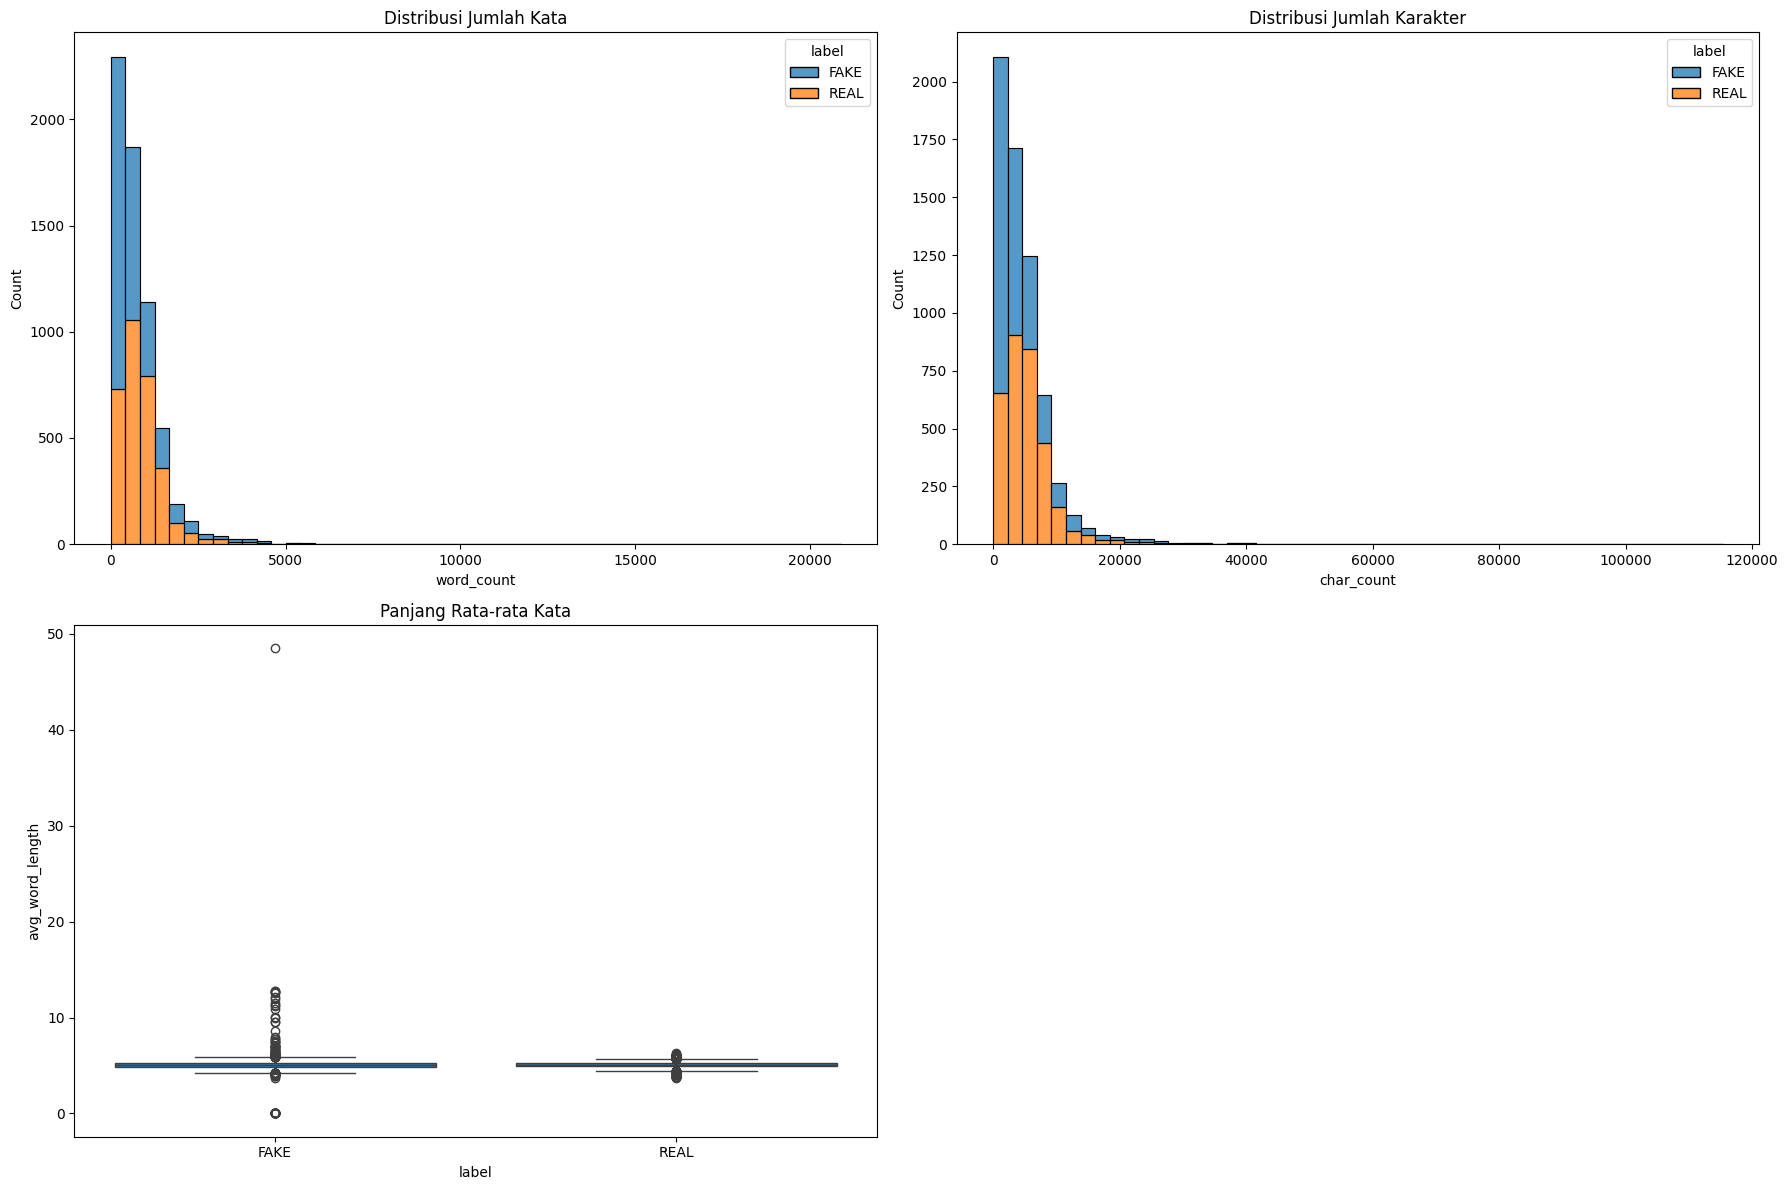

In [8]:
# Mengatur ukuran plot
plt.figure(figsize=(18, 12))

# Plot 1: Distribusi Jumlah Kata
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='word_count', hue='label', multiple='stack', bins=50)
plt.title('Distribusi Jumlah Kata')

# Plot 2: Distribusi Jumlah Karakter
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='char_count', hue='label', multiple='stack', bins=50)
plt.title('Distribusi Jumlah Karakter')

# Plot 3: Boxplot Panjang Rata-rata Kata
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='label', y='avg_word_length')
plt.title('Panjang Rata-rata Kata')

plt.tight_layout()
plt.show()

### 2.4 Analisis N-grams (Kata yang Sering Muncul)

C:\Users\asus\AppData\Local\Temp\ipykernel_49376\1715134263.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frekuensi', y='Kata/Frasa', data=top_words_df, palette='plasma')


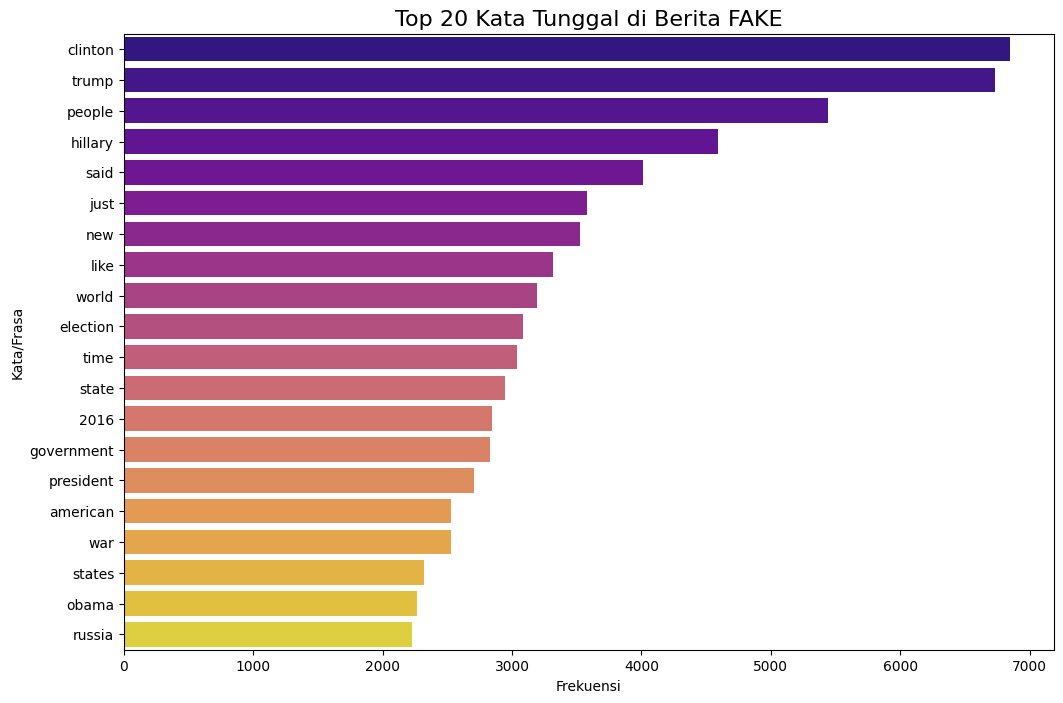

C:\Users\asus\AppData\Local\Temp\ipykernel_49376\1715134263.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frekuensi', y='Kata/Frasa', data=top_words_df, palette='plasma')


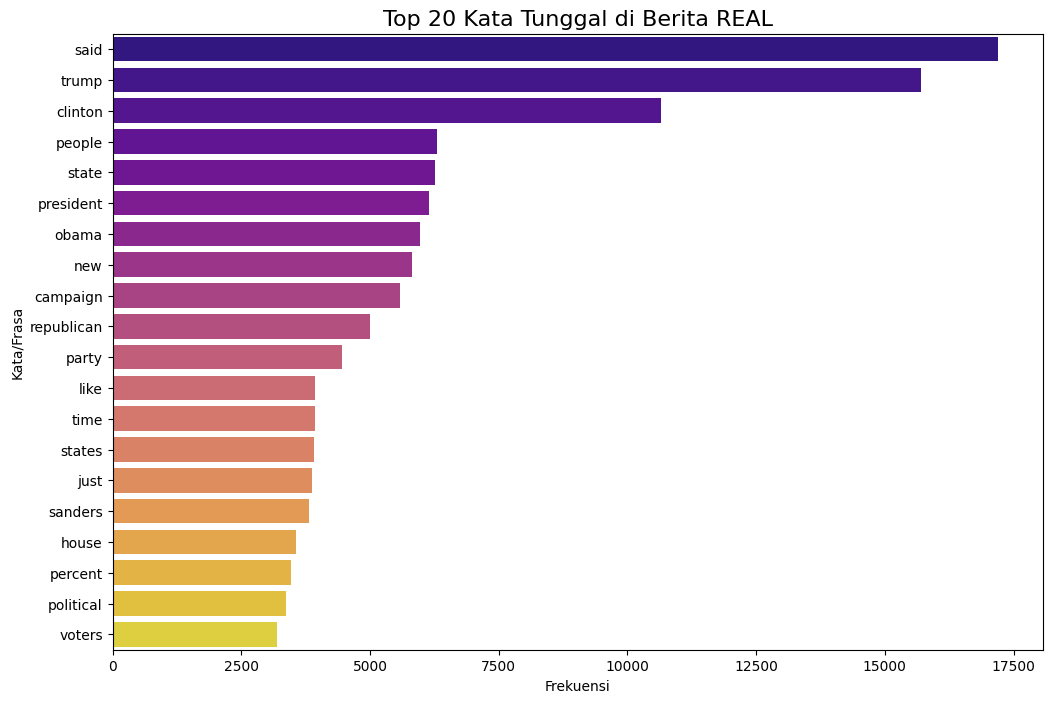

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Fungsi untuk membuat plot kata yang paling umum
def plot_top_ngrams(corpus, title, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    top_words_df = pd.DataFrame(words_freq[:n], columns=['Kata/Frasa', 'Frekuensi'])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frekuensi', y='Kata/Frasa', data=top_words_df, palette='plasma')
    plt.title(title, fontsize=16)
    plt.show()

# Pisahkan teks berita FAKE dan REAL
fake_news_text = df[df['label'] == 'FAKE']['text']
real_news_text = df[df['label'] == 'REAL']['text']

# Plot 20 kata tunggal (unigram) yang paling umum di berita FAKE
plot_top_ngrams(fake_news_text, 'Top 20 Kata Tunggal di Berita FAKE', ngram_range=(1,1))

# Plot 20 kata tunggal (unigram) yang paling umum di berita REAL
plot_top_ngrams(real_news_text, 'Top 20 Kata Tunggal di Berita REAL', ngram_range=(1,1))

## Kesimpulan Analisis

Dari Data Profiling yang mendalam ini, kita mendapatkan pemahaman yang lebih baik tentang dataset. Kita tidak hanya tahu bahwa datanya seimbang, tetapi juga menemukan fitur-fitur potensial seperti:
1.  **Panjang Teks**: Berita REAL cenderung lebih panjang.
2.  **Kata Kunci (N-grams)**: Ada perbedaan kosakata yang signifikan antara kedua jenis berita.

Informasi ini sangat berharga dan akan membantu model *machine learning* untuk belajar membedakan kedua kelas dengan lebih baik. Anda sekarang siap untuk melanjutkan ke tahap **Data Preprocessing** dan **Modeling**.